# Football Diffusion: End-to-End Pipeline

This notebook demonstrates:
1. Data preprocessing
2. Dataset inspection
3. Model evaluation and visualization

**Note**: Model training should be done via command-line:
```bash
python train_main.py --config src/football_diffusion/config/train.yaml
```

If you encounter PyArrow errors during preprocessing, restart the kernel (Kernel → Restart) and re-run all cells from the beginning.


In [1]:
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

# Add src to path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Force reload modules to avoid cached versions
modules_to_reload = [
    'football_diffusion.data.preprocess',
    'football_diffusion.data',
    'football_diffusion.viz',
    'football_diffusion.viz.field',
    'football_diffusion.viz.animate',
    'football_diffusion.viz.evaluate_play'
]
for mod_name in modules_to_reload:
    if mod_name in sys.modules:
        importlib.reload(sys.modules[mod_name])

from football_diffusion.data.preprocess import preprocess_all
from football_diffusion.data.dataset import FootballPlayDataset, collate_fn

# Import visualization functions (try from package first, fallback to direct imports)
try:
    from football_diffusion.viz import (
        plot_trajectory, 
        draw_field, 
        animate_trajectory,
        evaluate_play_quality,
        print_play_quality_report
    )
except ImportError:
    # Fallback: import directly from submodules
    print("Falling back to direct imports...")
    from football_diffusion.viz.field import plot_trajectory, draw_field
    from football_diffusion.viz.animate import animate_trajectory
    from football_diffusion.viz.evaluate_play import evaluate_play_quality, print_play_quality_report

from football_diffusion.utils.seed import set_seed

import yaml

# Set random seed for reproducibility
set_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("Modules loaded - ready for preprocessing and visualization")


PyTorch version: 2.8.0
Device: cpu
Modules loaded - ready for preprocessing and visualization


## 1. Data Preprocessing


In [2]:
# Load config and preprocess data
with open('../src/football_diffusion/config/default.yaml') as f:
    config = yaml.safe_load(f)

raw_dir = Path('../../data/nfl-big-data-bowl-2023')
cache_dir = Path('../../data/cache')
cache_dir.mkdir(parents=True, exist_ok=True)

# Set this to True to force re-preprocessing, False to use cache if available
rerun_preprocessing = True

cache_file = cache_dir / 'processed_plays.pkl'

if rerun_preprocessing:
    print("🔄 Re-running preprocessing (rerun_preprocessing=True)...")
    preprocess_all(raw_dir, cache_dir, config['data'])
    print("✅ Preprocessing complete!")
elif cache_file.exists():
    print(f"✅ Cache file found at {cache_file}")
    print("   Using cached data. Set rerun_preprocessing=True to re-run preprocessing.")
else:
    print("Cache file not found. Running preprocessing...")
    preprocess_all(raw_dir, cache_dir, config['data'])
    print("✅ Preprocessing complete!")


🔄 Re-running preprocessing (rerun_preprocessing=True)...
Loaded 1679 players from players.csv
Processing week1.csv...


Week 1: 100%|██████████| 1175/1175 [01:34<00:00, 12.49it/s]


Processing week2.csv...


Week 2: 100%|██████████| 1067/1067 [01:26<00:00, 12.29it/s]


Processing week3.csv...


Week 3: 100%|██████████| 1141/1141 [01:33<00:00, 12.15it/s]


Processing week4.csv...


Week 4: 100%|██████████| 1113/1113 [01:29<00:00, 12.45it/s]


Processing week5.csv...


Week 5: 100%|██████████| 1108/1108 [01:30<00:00, 12.24it/s]


Processing week6.csv...


Week 6: 100%|██████████| 1004/1004 [01:20<00:00, 12.49it/s]


Processing week7.csv...


Week 7: 100%|██████████| 917/917 [01:13<00:00, 12.40it/s]


Processing week8.csv...


Week 8: 100%|██████████| 1032/1032 [01:20<00:00, 12.82it/s]



Processed 8557 plays total

Computing normalization statistics...
  x: mean=60.2592, std=24.7559
  y: mean=26.5862, std=8.8202
  s: mean=3.0606, std=2.0902

Normalizing coordinates (mean=0, std=1 per feature)...
✅ Normalization complete
Saved to ../../data/cache/processed_plays.pkl
Summary CSV saved to ../../data/cache/processed_plays_summary.csv
Metadata saved with normalization stats for denormalization
✅ Preprocessing complete!


## 2. Load and Inspect Dataset


In [3]:
# Load datasets - use .pkl file (pickle format)
cache_file = cache_dir / 'processed_plays.pkl'
metadata_file = cache_dir / 'metadata.json'

train_dataset = FootballPlayDataset(cache_file, metadata_file, split='train')
print(f"Train: {len(train_dataset)} plays")

sample = train_dataset[0]
print(f"Sample shape: {sample['X'].shape}")
print(f"Context: {sample['context_categorical']}")


Train: 6608 plays
Sample shape: torch.Size([60, 22, 3])
Context: {'down': 3, 'offensiveFormation': 'SHOTGUN', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'DAL', 'situation': 'short'}


## 3. Model Training

**Training should be done via command-line**, not in this notebook.

Run training from the project root:
```bash
cd diffusion
python train_main.py --config src/football_diffusion/config/train.yaml \
    --cache_dir ../../data/cache \
    --output_dir ../../artifacts/diffusion \
    --gpus 1 \
    --max_epochs 50
```

Or use the provided script:
```bash
bash scripts/train_diffusion.sh
```

This will save model checkpoints to `../../artifacts/diffusion/` which can then be loaded for evaluation below.


## 4. Evaluation and Visualization


Sample play shape: torch.Size([60, 22, 3])
Context: {'down': 3, 'offensiveFormation': 'SHOTGUN', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'DAL', 'situation': 'short'}
✅ Loaded actual player positions from players.csv


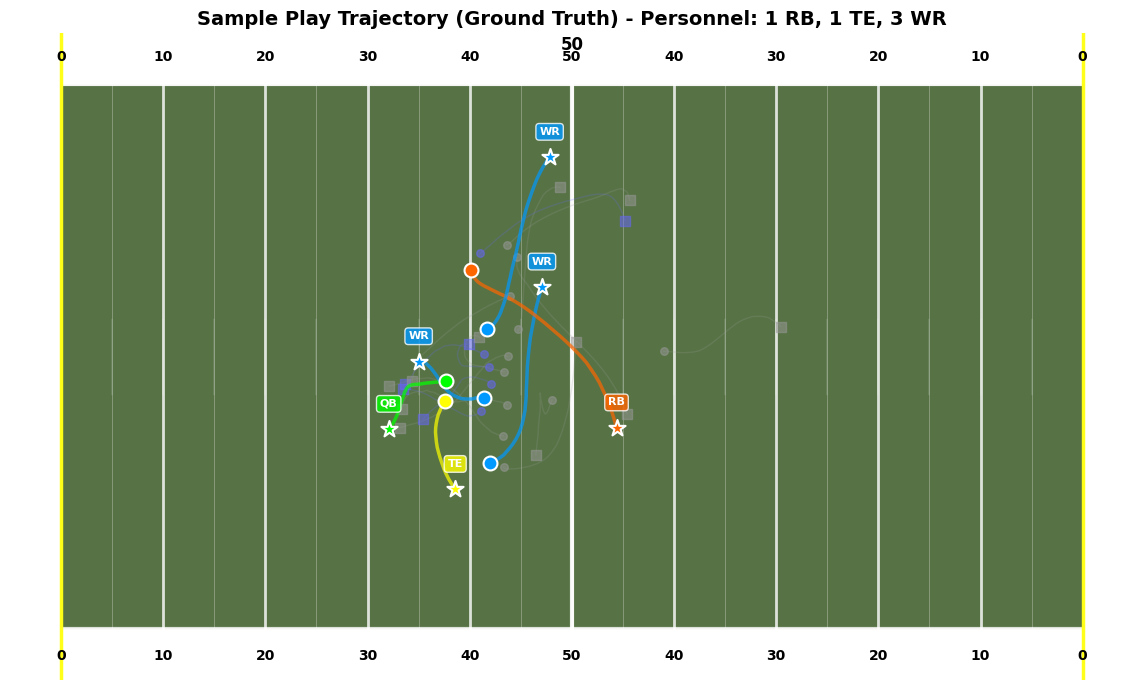


PLAY QUALITY EVALUATION
PLAY QUALITY REPORT
Overall Quality Score: 0.504

Validity Checks:
  ✓ Field Bounds:      100.0% valid
  ✓ Speed Cap:         100.0% valid
  ✓ Overall Validity:  100.0% valid

Realism Metrics:
  ✓ Smoothness:        0.987 (1.0 = perfectly smooth)
  ✓ Movement:          11.40 yards avg displacement
  ✓ Forward Progress:  0.42 yards
  ✓ Direction:         0.511 (1.0 = consistently forward)

Assessment: 🟠 FAIR


In [4]:
# Evaluation and visualization examples
# 
# To evaluate a trained model, use the command-line script:
# python -m src.football_diffusion.eval.eval_diffusion \
#     --checkpoint ../../artifacts/diffusion/best.ckpt \
#     --cache_dir ../../data/cache \
#     --config src/football_diffusion/config/eval.yaml \
#     --split test
#
# Or load a model for visualization:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example: Load a trained model (uncomment when you have a checkpoint)
# from football_diffusion.training.train_diffusion import DiffusionLightningModule
# model = DiffusionLightningModule.load_from_checkpoint(
#     '../../artifacts/diffusion/best.ckpt',
#     config=config
# )
# model.model = model.model.to(device)
# model.model.eval()

# Get a sample from the dataset for visualization
sample_play = train_dataset[0]
print(f"Sample play shape: {sample_play['X'].shape}")
print(f"Context: {sample_play['context_categorical']}")

# Visualize the ground truth trajectory with position labels
trajectory = sample_play['X'].numpy()  # [T, P, F]

# Try to load actual player positions from players.csv (most accurate!)
from football_diffusion.viz.load_real_positions import get_real_player_positions
personnel_str = sample_play['context_categorical'].get('personnelO', '')
game_id = sample_play.get('gameId')
play_id = sample_play.get('playId')

# Load actual positions if available
player_labels = None
if game_id and play_id:
    player_labels = get_real_player_positions(raw_dir, game_id, play_id)
    if player_labels:
        print(f"✅ Loaded actual player positions from players.csv")
    else:
        print(f"⚠️  Could not load positions from players.csv, using personnel inference")
else:
    print(f"⚠️  No game_id/play_id available, using personnel inference")

fig, ax = plt.subplots(figsize=(14, 7))
draw_field(ax)
plot_trajectory(
    trajectory, 
    ax=ax, 
    alpha=0.7,
    highlight_skill_only=True,  # Only highlight RB, WR, TE, QB
    show_path=True,
    player_labels=player_labels,  # Use actual positions if loaded
    personnel_str=personnel_str  # Fallback to personnel if positions not available
)
ax.set_title(f'Sample Play Trajectory (Ground Truth) - Personnel: {personnel_str}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Evaluate play quality
print("\n" + "="*60)
print("PLAY QUALITY EVALUATION")
print("="*60)
quality_metrics = evaluate_play_quality(trajectory)
print_play_quality_report(quality_metrics)


In [ ]:
## 5. Animated Visualization with Position Labels

# Animate trajectories showing only skill positions (RB, WR, TE, QB) moving, 
# while keeping other players static for clarity.


SyntaxError: invalid syntax (3663192312.py, line 3)

Visualizing play 0
Context: {'down': 3, 'offensiveFormation': 'SHOTGUN', 'personnelO': '1 RB, 1 TE, 3 WR', 'defTeam': 'DAL', 'situation': 'short'}
Personnel: 1 RB, 1 TE, 3 WR
Trajectory shape: (60, 22, 3)
✅ Using actual player positions from players.csv
   Positions: ['QB', 'TE', 'WR', 'RB', 'C', 'WR', 'T', 'G', 'WR', 'G', 'T'] (offense)


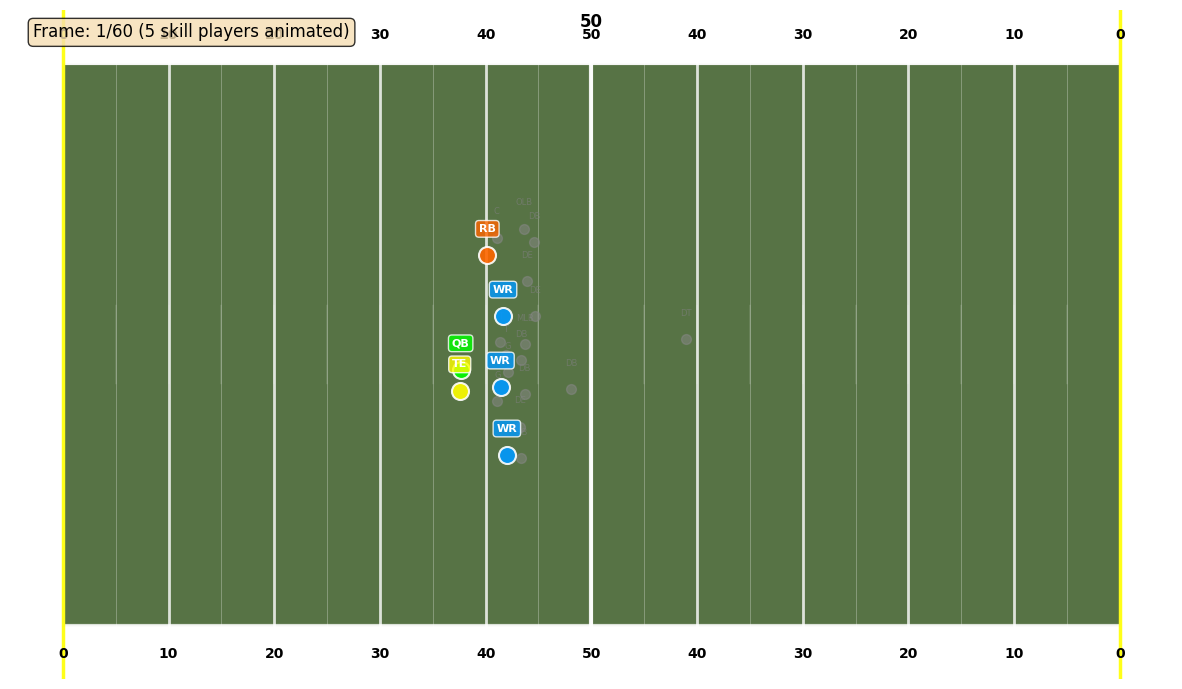

In [4]:
# Enable interactive plotting for animations in Jupyter
%matplotlib inline

# Get a sample trajectory for animation
sample_idx = 0  # Change this to visualize different plays
sample_play = train_dataset[sample_idx]
trajectory = sample_play['X'].numpy()  # [T, P, F]
personnel_str = sample_play['context_categorical'].get('personnelO', '')
game_id = sample_play.get('gameId')
play_id = sample_play.get('playId')

print(f"Visualizing play {sample_idx}")
print(f"Context: {sample_play['context_categorical']}")
print(f"Personnel: {personnel_str}")
print(f"Trajectory shape: {trajectory.shape}")

# Try to load actual player positions from players.csv (most accurate!)
from football_diffusion.viz.load_real_positions import get_real_player_positions
player_labels = None
if game_id and play_id:
    player_labels = get_real_player_positions(raw_dir, game_id, play_id)
    if player_labels:
        print(f"✅ Using actual player positions from players.csv")
        print(f"   Positions: {player_labels[:11]} (offense)")

# Create animated visualization
# This will show only skill positions (RB, WR, TE, QB) moving
# Other players (OL, defense) will be static gray dots
anim, fig = animate_trajectory(
    trajectory,
    interval=100,  # 100ms per frame
    show_field=True,
    animate_skill_only=True,  # Only animate skill positions
    show_trails=True,  # Show trajectory trails
    player_labels=player_labels,  # Use actual positions if loaded
    personnel_str=personnel_str,  # Fallback to personnel if positions not available
    raw_dir=raw_dir,  # Pass raw_dir to enable position loading
    game_id=game_id,
    play_id=play_id
)

# Display animation in Jupyter notebook
from IPython.display import HTML, display
try:
    # Convert to HTML5 video for inline display
    html_anim = HTML(anim.to_jshtml())
    display(html_anim)
except Exception as e:
    # Fallback: show static final frame and provide instructions
    plt.show()
    print(f"\n⚠️  Could not display interactive animation: {e}")
    print("\nTo see the animation, you can:")
    print("  1. Save it as a video (uncomment the line below)")
    print("  2. Use %matplotlib widget instead of inline (requires ipympl)")

# To save the animation as a video (uncomment to save):
# anim.save('sample_play_animation.mp4', writer='ffmpeg', fps=10, bitrate=1800)
# print("Animation saved to sample_play_animation.mp4")


In [ ]:
## 6. Evaluate Multiple Plays

Compare quality metrics across different plays.


In [5]:
# Evaluate multiple plays and compare
num_plays_to_evaluate = 5
print(f"Evaluating {num_plays_to_evaluate} random plays...\n")

all_qualities = []
for i in range(num_plays_to_evaluate):
    sample = train_dataset[i]
    traj = sample['X'].numpy()
    quality = evaluate_play_quality(traj)
    all_qualities.append(quality)
    
    # Context: categorical has 'down', continuous has 'yardsToGo' as first element
    context_cat = sample['context_categorical']
    context_cont = sample['context_continuous'].numpy()
    down = context_cat.get('down', '?')
    yards_to_go = context_cont[0] if len(context_cont) > 0 else '?'
    
    print(f"Play {i+1} - Context: Down {down} & {yards_to_go:.1f} yards to go")
    print(f"  Quality Score: {quality['quality_score']:.3f} | "
          f"Validity: {quality['overall_validity']*100:.1f}% | "
          f"Movement: {quality['movement']:.1f}yd")
    print()

# Summary statistics
avg_quality = np.mean([q['quality_score'] for q in all_qualities])
avg_validity = np.mean([q['overall_validity'] for q in all_qualities])
avg_movement = np.mean([q['movement'] for q in all_qualities])

print("="*60)
print(f"Average across {num_plays_to_evaluate} plays:")
print(f"  Quality Score: {avg_quality:.3f}")
print(f"  Validity: {avg_validity*100:.1f}%")
print(f"  Movement: {avg_movement:.1f} yards")
print("="*60)


Evaluating 5 random plays...

Play 1 - Context: Down 3 & 2.0 yards to go
  Quality Score: 0.504 | Validity: 100.0% | Movement: 11.4yd

Play 2 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.534 | Validity: 100.0% | Movement: 7.7yd

Play 3 - Context: Down 2 & 6.0 yards to go
  Quality Score: 0.550 | Validity: 100.0% | Movement: 6.2yd

Play 4 - Context: Down 1 & 10.0 yards to go
  Quality Score: 0.523 | Validity: 100.0% | Movement: 9.1yd

Play 5 - Context: Down 3 & 15.0 yards to go
  Quality Score: 0.516 | Validity: 100.0% | Movement: 8.5yd

Average across 5 plays:
  Quality Score: 0.525
  Validity: 100.0%
  Movement: 8.6 yards


## 5. Custom Play Generation

Generate plays with custom conditioning (down, distance, formation, personnel, defense, yardline).


✅ Found best model checkpoint: epoch=47-val_loss=0.0000-v1.ckpt
📦 Loading model from: /Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/artifacts/diffusion/epoch=47-val_loss=0.0000-v1.ckpt
   Full path: /Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/artifacts/diffusion/epoch=47-val_loss=0.0000-v1.ckpt
✅ Model loaded on device: cpu
   Weight stats: mean=0.006704, std=0.043356

🎯 Generating play with context:
   Down: 2 & 5
   Formation: SHOTGUN
   Personnel: 1 RB, 1 TE, 3 WR
   Defensive Team: DAL
   Yardline: 50 (normalized: 0.50)
   Situation: medium

🎨 Generating play... (this may take a moment)
   Sampling with 50 steps...
   Raw output range - X: [-2.49, 2.65], Y: [-2.93, 2.25]

🔍 Comparing with real play from dataset:
   Real play - X: [32.07, 70.47], Y: [13.66, 46.17]

📊 Generated coordinate ranges (raw, before clipping):
   X: [-2.49, 2.65] (expected: 0-100)
   Y: [-2.93, 2.25] (expected: 0-53.3)
   X mean: 0.02, std: 0.

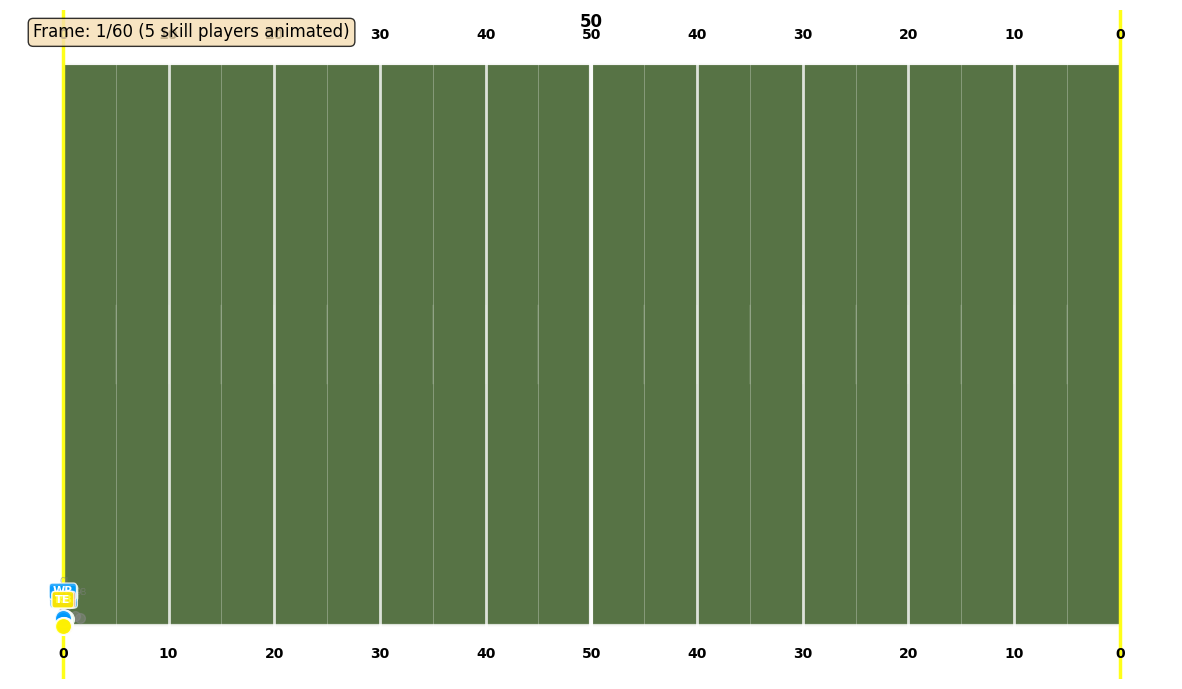

In [ ]:
# Custom Play Generation
# Modify these parameters to generate plays for any scenario

from football_diffusion.training.train_diffusion import DiffusionLightningModule
from football_diffusion.data.preprocess import derive_situation
from IPython.display import HTML
import torch
import json
from pathlib import Path

# ============================================================================
# CUSTOM CONTEXT PARAMETERS - MODIFY THESE
# ============================================================================
CUSTOM_DOWN = 2                   # Down (1-4)
CUSTOM_YARDS_TO_GO = 5             # Yards needed for first down
CUSTOM_OFFENSIVE_FORMATION = "SHOTGUN"  # Formation (e.g., "SHOTGUN", "UNDER CENTER", "EMPTY")
CUSTOM_PERSONNEL_O = "1 RB, 1 TE, 3 WR"  # Personnel (e.g., "1 RB, 1 TE, 3 WR")
CUSTOM_DEF_TEAM = "DAL"            # Defensive team abbreviation
CUSTOM_YARDLINE = 50               # Yardline (0-100, distance from own goal line)

# Sampling parameters
NUM_SAMPLING_STEPS = 50            # Number of denoising steps (more = better quality, slower)
GUIDANCE_SCALE = 2.0               # Classifier-free guidance scale

# ============================================================================
# LOAD MODEL
# ============================================================================
# Load config
config_path = Path('../src/football_diffusion/config/default.yaml')
with open(config_path) as f:
    config = yaml.safe_load(f)

# Ensure cache_dir is defined (from earlier cells)
if 'cache_dir' not in locals():
    cache_dir = Path('../../data/cache')

# Load trained model - specify the best model checkpoint
# Update this path to point to your best trained model
# Using absolute path for clarity
# NEW: Using checkpoint trained with fixed tensor shapes (epoch=47)
BEST_CHECKPOINT = Path('/Users/sanjjithdinesh/GT/fall 25/deep learning/DL project/nfl_play_suggestion/artifacts/diffusion/epoch=47-val_loss=0.0000-v1.ckpt')

# Also try relative path as fallback
if not BEST_CHECKPOINT.exists():
    BEST_CHECKPOINT = Path('../../artifacts/diffusion/epoch=47-val_loss=0.0000-v1.ckpt')

# Fallback logic: try best checkpoint, then last.ckpt, then any checkpoint
checkpoint_path = None

if BEST_CHECKPOINT.exists():
    checkpoint_path = BEST_CHECKPOINT
    print(f"✅ Found best model checkpoint: {BEST_CHECKPOINT.name}")
else:
    # Try last.ckpt
    last_ckpt = Path('../../artifacts/diffusion/last.ckpt')
    if last_ckpt.exists():
        checkpoint_path = last_ckpt
        print(f"⚠️  Best checkpoint not found. Using: {last_ckpt.name}")
    else:
        # Try to find any checkpoint
        checkpoint_dir = Path('../../artifacts/diffusion')
        ckpts = list(checkpoint_dir.glob('*.ckpt'))
        if ckpts:
            # Sort by modification time, use most recent
            ckpts.sort(key=lambda x: x.stat().st_mtime, reverse=True)
            checkpoint_path = ckpts[0]
            print(f"⚠️  Using most recent checkpoint: {checkpoint_path.name}")
        else:
            raise FileNotFoundError(
                f"No checkpoint found. Expected:\n"
                f"  - {BEST_CHECKPOINT}\n"
                f"  - {last_ckpt}\n"
                f"  - Or any .ckpt file in {checkpoint_dir}\n"
                "Please train the model first or update the checkpoint path."
            )

print(f"📦 Loading model from: {checkpoint_path}")
print(f"   Full path: {checkpoint_path.absolute()}")

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    module = DiffusionLightningModule.load_from_checkpoint(
        str(checkpoint_path),
        config=config
    )
    model = module.model.to(device)
    model.eval()
    print(f"✅ Model loaded on device: {device}")
    
    # Verify checkpoint info
    if hasattr(module, 'hyper_parameters'):
        hparams = module.hyper_parameters
        print(f"   Model config: {hparams.get('num_players', 'N/A')} players, {hparams.get('num_features', 'N/A')} features")
    
    # Check if model was actually trained by verifying some weights
    with torch.no_grad():
        sample_weight = list(model.model.parameters())[0]
        weight_mean = sample_weight.mean().item()
        weight_std = sample_weight.std().item()
        print(f"   Weight stats: mean={weight_mean:.6f}, std={weight_std:.6f}")
        if abs(weight_mean) < 0.0001 and weight_std < 0.01:
            print(f"   ⚠️  WARNING: Weights are very small - model may not be trained!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    import traceback
    traceback.print_exc()
    raise

# ============================================================================
# BUILD CONTEXT
# ============================================================================
# Derive situation from down and yards to go
situation = derive_situation(CUSTOM_DOWN, CUSTOM_YARDS_TO_GO)

# Normalize yardline to [0, 1] (0 = own goal line, 1 = opponent goal line)
yardline_norm = CUSTOM_YARDLINE / 100.0

# Build categorical context
context_categorical = [{
    'down': CUSTOM_DOWN,
    'offensiveFormation': CUSTOM_OFFENSIVE_FORMATION,
    'personnelO': CUSTOM_PERSONNEL_O,
    'defTeam': CUSTOM_DEF_TEAM,
    'situation': situation
}]

# Build continuous context [yardsToGo, yardlineNorm]
context_continuous = torch.tensor(
    [[CUSTOM_YARDS_TO_GO, yardline_norm]],
    dtype=torch.float32
).to(device)

print(f"\n🎯 Generating play with context:")
print(f"   Down: {CUSTOM_DOWN} & {CUSTOM_YARDS_TO_GO}")
print(f"   Formation: {CUSTOM_OFFENSIVE_FORMATION}")
print(f"   Personnel: {CUSTOM_PERSONNEL_O}")
print(f"   Defensive Team: {CUSTOM_DEF_TEAM}")
print(f"   Yardline: {CUSTOM_YARDLINE} (normalized: {yardline_norm:.2f})")
print(f"   Situation: {situation}")

# ============================================================================
# GENERATE PLAY
# ============================================================================
print(f"\n🎨 Generating play... (this may take a moment)")

with torch.no_grad():
    # Get tensor shape from metadata
    metadata_file = cache_dir / 'metadata.json'
    if metadata_file.exists():
        with open(metadata_file) as f:
            metadata = json.load(f)
        T = metadata.get('frames', 60)
        P = metadata.get('players', 22)
        F = len(metadata.get('features', ['x', 'y', 's']))
    else:
        T, P, F = 60, 22, 3
    
    # Generate play
    print(f"   Sampling with {NUM_SAMPLING_STEPS} steps...")
    generated_trajectory = model.sample(
        shape=(T, P, F),
        context_categorical=context_categorical,
        context_continuous=context_continuous,
        num_steps=NUM_SAMPLING_STEPS
    )
    
    # Check intermediate coordinate ranges after generation (before any clipping)
    x_raw = generated_trajectory[0, :, :, 0].cpu().numpy()
    y_raw = generated_trajectory[0, :, :, 1].cpu().numpy()
    print(f"   Raw output range - X: [{x_raw.min():.2f}, {x_raw.max():.2f}], Y: [{y_raw.min():.2f}, {y_raw.max():.2f}]")
    
    # Convert to numpy (model outputs normalized coordinates)
    generated_trajectory = generated_trajectory[0].cpu().numpy()  # [T, P, F] - normalized
    
    # DENORMALIZE coordinates back to field space
    from football_diffusion.data.normalize import denormalize_tensor
    
    if 'normalization' in train_dataset.metadata:
        normalization_stats = train_dataset.metadata['normalization']
        print(f"\n🔄 Denormalizing coordinates using stored stats...")
        print(f"   Feature means: {[f'{m:.4f}' for m in normalization_stats['means']]}")
        print(f"   Feature stds: {[f'{s:.4f}' for s in normalization_stats['stds']]}")
        generated_trajectory = denormalize_tensor(generated_trajectory, normalization_stats)
        print(f"   ✅ Denormalized to field coordinates")
    else:
        print(f"\n⚠️  No normalization stats found - coordinates are already in field space")
    
    # Compare with a real play from the dataset (also denormalize if needed)
    print(f"\n🔍 Comparing with real play from dataset:")
    real_sample = train_dataset[0]
    real_traj = real_sample['X'].numpy()
    
    # Denormalize real play too if normalization was applied
    if 'normalization' in train_dataset.metadata:
        real_traj = denormalize_tensor(real_traj, train_dataset.metadata['normalization'])
    
    real_x = real_traj[:, :, 0]
    real_y = real_traj[:, :, 1]
    print(f"   Real play - X: [{real_x.min():.2f}, {real_x.max():.2f}], Y: [{real_y.min():.2f}, {real_y.max():.2f}]")
    
    # Check coordinate ranges (now in field space)
    x_coords = generated_trajectory[:, :, 0].copy()
    y_coords = generated_trajectory[:, :, 1].copy()
    print(f"\n📊 Generated coordinate ranges (denormalized, field space):")
    print(f"   X: [{x_coords.min():.2f}, {x_coords.max():.2f}] (expected: ~0-100)")
    print(f"   Y: [{y_coords.min():.2f}, {y_coords.max():.2f}] (expected: ~0-53.3)")
    print(f"   X mean: {x_coords.mean():.2f}, std: {x_coords.std():.2f}")
    print(f"   Y mean: {y_coords.mean():.2f}, std: {y_coords.std():.2f}")
    
    # Check if coordinates are reasonable
    x_mean_expected = 50  # Middle of field
    y_mean_expected = 27  # Middle of field width
    x_range_expected = (0, 100)
    y_range_expected = (0, 53.3)
    
    if (x_range_expected[0] - 10 <= x_coords.mean() <= x_range_expected[1] + 10 and
        y_range_expected[0] - 10 <= y_coords.mean() <= y_range_expected[1] + 10):
        print(f"\n✅ Coordinates look reasonable! Mean is within expected field bounds.")
    else:
        print(f"\n⚠️  WARNING: Coordinates seem unusual!")
        print(f"   Real plays have mean X: {real_x.mean():.2f}, mean Y: {real_y.mean():.2f}")
        print(f"   Generated plays have mean X: {x_coords.mean():.2f}, mean Y: {y_coords.mean():.2f}")
    
    # Clip coordinates to valid field bounds
    generated_trajectory[:, :, 0] = np.clip(generated_trajectory[:, :, 0], 0, 100)
    generated_trajectory[:, :, 1] = np.clip(generated_trajectory[:, :, 1], 0, 53.3)
    
    print(f"\n✅ Coordinates clipped to field bounds [0-100, 0-53.3]")

print(f"✅ Play generated! Shape: {generated_trajectory.shape}")

# ============================================================================
# VISUALIZE GENERATED PLAY
# ============================================================================
print(f"\n🎬 Animating generated play...")

# Generate position labels based on personnel (approximate)
from football_diffusion.viz.position_utils import parse_personnel

counts = parse_personnel(CUSTOM_PERSONNEL_O)
# Build labels: QB + skill positions + OL + Defense
player_labels = ['QB']  # Index 0 is always QB with fixed ordering
player_labels.extend(['WR'] * counts.get('WR', 0))
player_labels.extend(['RB'] * counts.get('RB', 0))
player_labels.extend(['TE'] * counts.get('TE', 0))
# Pad offense to 11 players with OL
while len(player_labels) < 11:
    player_labels.append('OL')
player_labels = player_labels[:11]
# Add defense (11 players)
player_labels.extend(['DB'] * 11)

# Animate the generated play
%matplotlib inline
from IPython.display import HTML

anim, _ = animate_trajectory(
    generated_trajectory,
    player_labels=player_labels,
    personnel_str=CUSTOM_PERSONNEL_O,
    animate_skill_only=True,  # Only animate skill positions
    show_trails=True
)

# Display animation
HTML(anim.to_jshtml())

print(f"\n✅ Done! Modify the parameters above to generate different scenarios.")
